In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

/home/william/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df_paths = [
    "/home/william/lidar_data/Baselines/metrics.csv",
    "/home/william/lidar_data/PRA_Pedestrians/regular_runs/metrics.csv",
    "/home/william/lidar_data/PRA_Pedestrians/single_runs/metrics.csv",
    "/home/william/lidar_data/PRA_Vehicles/regular_runs/metrics.csv",
    "/home/william/lidar_data/PRA_Vehicles/single_runs/metrics.csv",
    # "/home/william/lidar_data/ORA_Pedestrians/regular_runs/metrics.csv",
    # "/home/william/lidar_data/ORA_Pedestrians/single_runs/metrics.csv",
    # "/home/william/lidar_data/ORA_Vehicles/regular_runs/metrics.csv",
    # "/home/william/lidar_data/ORA_Vehicles/single_runs/metrics.csv",
]

# join all dataframes
df = pd.concat([pd.read_csv(path) for path in df_paths])

In [3]:
# organize based on the run_id by adding columns for PRA/ORA, pedestrian/vehicle, attack angle, point budget, and attack distance

# if PRA, the run id will look like "PRA_pedestrians_10_stereo_scenario_0"
# meaning the scenario is "stereo_scenario_0", the attack is PRA, attacking pedestrians, 10 degree attack angle

# if ORA, the run id will look like "ORA_pedestrians_10_3m_stereo_scenario_0"
# meaning the scenario is "stereo_scenario_0", the attack is ORA, attacking pedestrians, point budget of 10, 3m attack distance

# if Baseline, the run id will look like "baseline_stereo_scenario_0"
df["PRA"] = df["run_id"].apply(lambda x: "PRA" in x)
df["ORA"] = df["run_id"].apply(lambda x: "ORA" in x)
df["Baseline"] = df["run_id"].apply(lambda x: "baseline" in x)
df["pedestrians"] = df["run_id"].apply(lambda x: "pedestrians" in x)
df["vehicles"] = df["run_id"].apply(lambda x: "vehicles" in x)
df["attack_angle"] = df["run_id"].apply(lambda x: int(x.split("_")[2]) if "PRA" in x else None)
df["point_budget"] = df["run_id"].apply(lambda x: int(x.split("_")[2]) if "ORA" in x else None)
df["attack_distance"] = df["run_id"].apply(lambda x: int(x.split("_")[3][:-1]) if "ORA" in x else None)
df["scenario"] = df["run_id"].apply(lambda x: x.split("_")[-1])

# get if we're using stereo, stacked, or single
configs = {"stereo", "stacked", "single"}
df["cam_config"] = df["run_id"].apply(lambda x: next((config for config in configs if config in x), None))

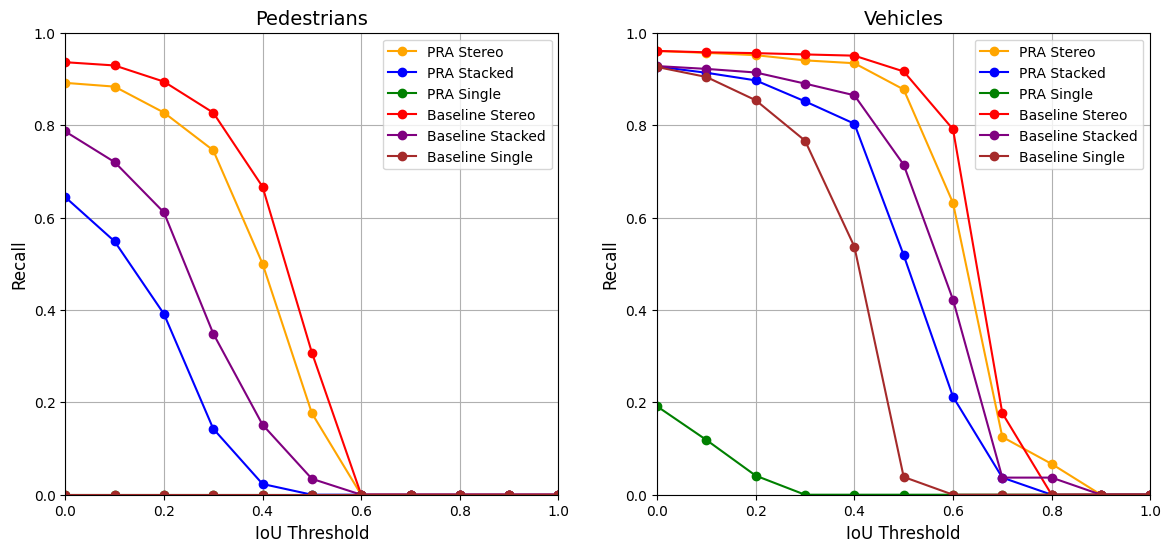

In [5]:
# create two plots side by side, one for pedestrians, one for vehicles

# filter out scenario 0
# df = df[df["scenario"] != "0"]

ped_attack_angle = 10
veh_attack_angle = 45

# recall over iou threshold for pedestrian with baseline stereo
df_ped_baseline_stereo = df[(df["Baseline"]) & (df["cam_config"] == "stereo") & (df["class"] == "PEDESTRIAN")]
recall_ped_baseline_stereo = df_ped_baseline_stereo.groupby("iou_threshold")["recall"].mean()

# recall over iou threshold for pedestrian with baseline stacked
df_ped_baseline_stacked = df[(df["Baseline"]) & (df["cam_config"] == "stacked") & (df["class"] == "PEDESTRIAN")]
recall_ped_baseline_stacked = df_ped_baseline_stacked.groupby("iou_threshold")["recall"].mean()

# recall over iou threshold for pedestrian with baseline single
df_ped_baseline_single = df[(df["Baseline"]) & (df["cam_config"] == "single") & (df["class"] == "PEDESTRIAN")]
recall_ped_baseline_single = df_ped_baseline_single.groupby("iou_threshold")["recall"].mean()

# recall over iou threshold for pedestrian PRA with stereo
df_ped_pra_stereo = df[(df["PRA"]) & (df["pedestrians"]) & (df["cam_config"] == "stereo") & (df["class"] == "PEDESTRIAN") & (df["attack_angle"] == ped_attack_angle)]
recall_ped_stereo = df_ped_pra_stereo.groupby("iou_threshold")["recall"].mean()

# recall over iou threshold for pedestrian PRA with stacked
df_ped_pra_stacked = df[(df["PRA"]) & (df["pedestrians"]) & (df["cam_config"] == "stacked") & (df["class"] == "PEDESTRIAN") & (df["attack_angle"] == ped_attack_angle)]
recall_ped_stacked = df_ped_pra_stacked.groupby("iou_threshold")["recall"].mean()

# recall over iou threshold for pedestrian PRA with single
df_ped_pra_single = df[(df["PRA"]) & (df["pedestrians"]) & (df["cam_config"] == "single") & (df["class"] == "PEDESTRIAN") & (df["attack_angle"] == ped_attack_angle)]
recall_ped_single = df_ped_pra_single.groupby("iou_threshold")["recall"].mean()

# recall over iou threshold for vehicle with baseline stereo
df_veh_baseline_stereo = df[(df["Baseline"]) & (df["cam_config"] == "stereo") & (df["class"] == "CAR")]
recall_veh_baseline_stereo = df_veh_baseline_stereo.groupby("iou_threshold")["recall"].mean()

# recall over iou threshold for vehicle with baseline stacked
df_veh_baseline_stacked = df[(df["Baseline"]) & (df["cam_config"] == "stacked") & (df["class"] == "CAR")]
recall_veh_baseline_stacked = df_veh_baseline_stacked.groupby("iou_threshold")["recall"].mean()

# recall over iou threshold for vehicle with baseline single
df_veh_baseline_single = df[(df["Baseline"]) & (df["cam_config"] == "single") & (df["class"] == "CAR")]
recall_veh_baseline_single = df_veh_baseline_single.groupby("iou_threshold")["recall"].mean()

# recale over iou threshold for vehicle PRA with stereo
df_veh_pra_stereo = df[(df["PRA"]) & (df["vehicles"]) & (df["cam_config"] == "stereo") & (df["class"] == "CAR") & (df["attack_angle"] == veh_attack_angle)]
recall_veh_stereo = df_veh_pra_stereo.groupby("iou_threshold")["recall"].mean()

# recall over iou threshold for vehicle PRA with stacked
df_veh_pra_stacked = df[(df["PRA"]) & (df["vehicles"]) & (df["cam_config"] == "stacked") & (df["class"] == "CAR") & (df["attack_angle"] == veh_attack_angle)]
recall_veh_stacked = df_veh_pra_stacked.groupby("iou_threshold")["recall"].mean()

# recall over iou threshold for vehicle PRA with single
df_veh_pra_single = df[(df["PRA"]) & (df["vehicles"]) & (df["cam_config"] == "single") & (df["class"] == "CAR") & (df["attack_angle"] == veh_attack_angle)]
recall_veh_single = df_veh_pra_single.groupby("iou_threshold")["recall"].mean()

# create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# plot lines for each pedestrian configuration
axs[0].plot(recall_ped_stereo, label="PRA Stereo", color="orange", marker="o")
axs[0].plot(recall_ped_stacked, label="PRA Stacked", color="blue", marker="o")
axs[0].plot(recall_ped_single, label="PRA Single", color="green", marker="o")
axs[0].plot(recall_ped_baseline_stereo, label="Baseline Stereo", color="red", marker="o")
axs[0].plot(recall_ped_baseline_stacked, label="Baseline Stacked", color="purple", marker="o")
axs[0].plot(recall_ped_baseline_single, label="Baseline Single", color="brown", marker="o")
axs[0].set_xticks(np.arange(0, 1.1, 0.2))
axs[0].set_yticks(np.arange(0, 1.1, 0.2))
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0, 1)
axs[0].grid()
axs[0].set_xlabel("IoU Threshold", fontsize=12)
axs[0].set_ylabel("Recall", fontsize=12)
axs[0].set_title("Pedestrians", fontsize=14)
axs[0].legend()

# plot lines for each vehicle configuration
axs[1].plot(recall_veh_stereo, label="PRA Stereo", color="orange", marker="o")
axs[1].plot(recall_veh_stacked, label="PRA Stacked", color="blue", marker="o")
axs[1].plot(recall_veh_single, label="PRA Single", color="green", marker="o")
axs[1].plot(recall_veh_baseline_stereo, label="Baseline Stereo", color="red", marker="o")
axs[1].plot(recall_veh_baseline_stacked, label="Baseline Stacked", color="purple", marker="o")
axs[1].plot(recall_veh_baseline_single, label="Baseline Single", color="brown", marker="o")
axs[1].set_xticks(np.arange(0, 1.1, 0.2))
axs[1].set_yticks(np.arange(0, 1.1, 0.2))
axs[1].set_ylim(0, 1)
axs[1].set_xlim(0, 1)
axs[1].grid()
axs[1].set_xlabel("IoU Threshold", fontsize=12)
axs[1].set_ylabel("Recall", fontsize=12)
axs[1].set_title("Vehicles", fontsize=14)
axs[1].legend()

# plt.tight_layout()
plt.show()
